In [1]:
import ast
import pandas as pd
%pip install jsonlines
import jsonlines as jl
import matplotlib.pyplot as plt

%pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
import string
import re
%pip install wordcloud
from wordcloud import WordCloud


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
df01 = pd.read_csv('1_Data/Raw_Data/train_preprocessed.csv')
df02 = pd.read_csv('1_Data/Raw_Data/test_preprocessed.csv')
df03 = pd.read_csv('1_Data/Raw_Data/dev_preprocessed.csv')
df = pd.concat([df01, df02, df03], ignore_index=True)

add_df = pd.read_excel('1_Data/Raw_Data/additional_data.xls')
train_df_old = pd.read_csv('1_Data/Raw_Data/train_old.csv')

### Distribution of data points by label

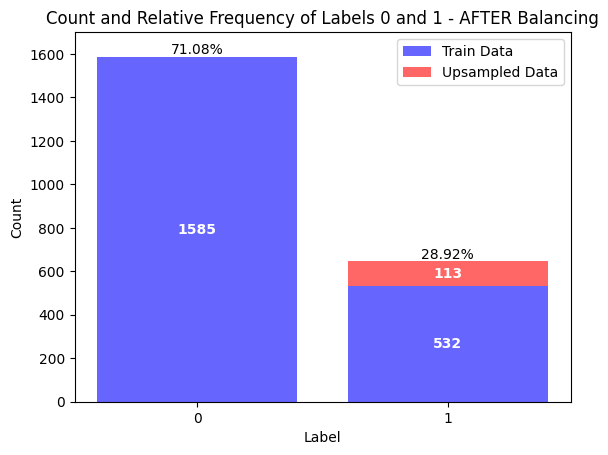

In [4]:
#extend the train_df with the add_df for a more balanced training set
train_df = pd.concat([train_df_old, add_df], ignore_index=True)

#count the labels in the DataFrames
label_counts_old = train_df_old['label'].value_counts().sort_index()
label_counts_add = add_df['label'].value_counts().sort_index()
label_counts = train_df['label'].value_counts().sort_index()

#ensure only labels 0 and 1 are included
label_counts_old = label_counts_old.reindex([0, 1], fill_value=0)
label_counts_add = label_counts_add.reindex([0, 1], fill_value=0)
label_counts = label_counts.reindex([0, 1], fill_value=0)

#plotting
fig, ax = plt.subplots()

#bar chart for the old train_df
bars1 = ax.bar(label_counts_old.index, label_counts_old.values, color='blue', alpha=0.6, label='Train Data')

#bar chart for the additional data (add_df) on top of the old train_df for label 1
bars2 = ax.bar(label_counts_add.index, label_counts_add.values, bottom=label_counts_old.values, color='red', alpha=0.6, label='Upsampled Data')

#adding labels and title
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Count and Relative Frequency of Labels 0 and 1 - AFTER Balancing')
ax.set_xticks([0, 1])
ax.set_ylim(0, 1700)  # Set maximum y-axis limit to 1700

#adding total count and percentage labels
total = label_counts.sum()
for i in range(len(bars1)):
    total_height = bars1[i].get_height() + bars2[i].get_height()
    count_label = f'{total_height}'
    percentage_label = f'{(total_height / total * 100):.2f}%'
    
    ax.text(bars1[i].get_x() + bars1[i].get_width() / 2.0, total_height, percentage_label, ha='center', va='bottom')
    ax.text(bars1[i].get_x() + bars1[i].get_width() / 2.0, bars1[i].get_height() / 2.0, f'{bars1[i].get_height()}', ha='center', va='center', color='white', fontweight='bold')
    
    # For label 1, also show the count for the red part (additional data)
    if i == 1:
        ax.text(bars2[i].get_x() + bars2[i].get_width() / 2.0, bars1[i].get_height() + bars2[i].get_height() / 2.0, f'{bars2[i].get_height()}', ha='center', va='center', color='white', fontweight='bold')

#adding legend
ax.legend()

#show plot
plt.show()

In [5]:
#count the number of words in the original text
def word_counter(text):

    #ensure the input is a string
    if not isinstance(text, str):
        raise ValueError("Input must be a string.")
    
    #split the text into words and count them
    word_count = len(text.split())
    
    return word_count



### Calculate text length and number of tokens

In [6]:
df['actual_word_count'] = df['text'].apply(word_counter)

#count number of tokwns in preprocessed text
df['preprocessed_word_count'] = df['Preprocessed'].apply(lambda x: len(ast.literal_eval(x)))

In [7]:
df

,text,label,Preprocessed,actual_word_count,preprocessed_word_count
0,The project will make a significant contributi...,1,"['project', 'make', 'significant', 'contributi...",22,12
1,"So in -- first of all, the segments, we are --...",0,"['first', 'segment', 'selective', 'past']",21,4
2,Building a smarter and stronger energy grid th...,0,"['building', 'smarter', 'stronger', 'energy', ...",23,14
3,"Generally, first of all our Transmission depar...",0,"['generally', 'first', 'transmission', 'depart...",25,13
4,"But for the most part, our challenge is showin...",0,"['part', 'challenge', 'showing', 'fund', 'work...",22,10
...,...,...,...,...,...
2642,"In addition, Aurizon analyses climate change p...",0,"['addition', 'aurizon', 'analysis', 'climate',...",26,19
2643,"RENEWABLE ENERGY POLICY Since 2001, regulatory...",0,"['renewable', 'energy', 'policy', 'since', '20...",23,17
2644,"The Diamond Green Diesel project spills over, ...",0,"['diamond', 'green', 'diesel', 'project', 'spi...",28,14
2645,I think when you look at our major cost saving...,0,"['think', 'look', 'major', 'cost', 'saving', '...",21,11


In [8]:
df['stopwords_rate'] = (df['actual_word_count'] - df['preprocessed_word_count']) / df['actual_word_count']

In [9]:
df

,text,label,Preprocessed,actual_word_count,preprocessed_word_count,stopwords_rate
0,The project will make a significant contributi...,1,"['project', 'make', 'significant', 'contributi...",22,12,0.454545
1,"So in -- first of all, the segments, we are --...",0,"['first', 'segment', 'selective', 'past']",21,4,0.809524
2,Building a smarter and stronger energy grid th...,0,"['building', 'smarter', 'stronger', 'energy', ...",23,14,0.391304
3,"Generally, first of all our Transmission depar...",0,"['generally', 'first', 'transmission', 'depart...",25,13,0.480000
4,"But for the most part, our challenge is showin...",0,"['part', 'challenge', 'showing', 'fund', 'work...",22,10,0.545455
...,...,...,...,...,...,...
2642,"In addition, Aurizon analyses climate change p...",0,"['addition', 'aurizon', 'analysis', 'climate',...",26,19,0.269231
2643,"RENEWABLE ENERGY POLICY Since 2001, regulatory...",0,"['renewable', 'energy', 'policy', 'since', '20...",23,17,0.260870
2644,"The Diamond Green Diesel project spills over, ...",0,"['diamond', 'green', 'diesel', 'project', 'spi...",28,14,0.500000
2645,I think when you look at our major cost saving...,0,"['think', 'look', 'major', 'cost', 'saving', '...",21,11,0.476190


### Frequency of Stopwprds by Label

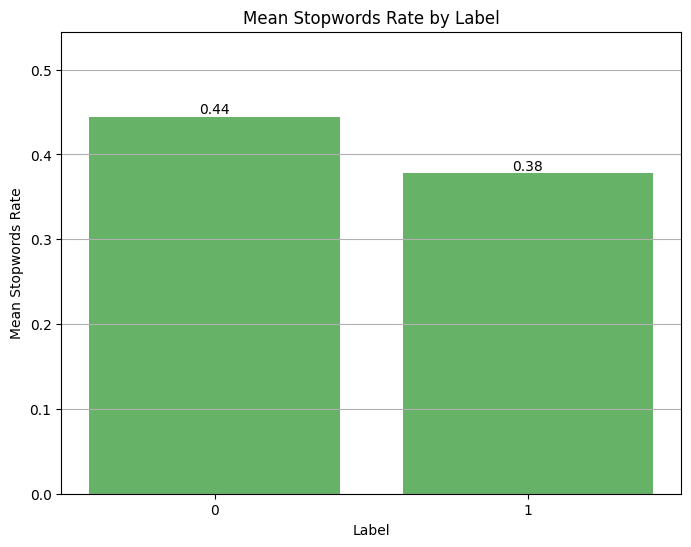

In [16]:
swr = df.groupby('label')['stopwords_rate'].mean()

plt.figure(figsize=(8, 6))
bars = plt.bar(swr.index.astype(str), swr.values, color='green', alpha=0.6)
plt.xlabel('Label')
plt.ylabel('Mean Stopwords Rate')
plt.title('Mean Stopwords Rate by Label')
plt.xticks(swr.index.astype(str))
plt.ylim(0, max(swr.values) + 0.1)
plt.grid(axis='y')

#adding the labels on top of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

#show the plot
plt.show()

Environmental claims show a higher frequency of stopwords. This shows that these sentences are written in more fact-stating way, whereas the other ones are written in a more converaational style.

### Word count comparison

In [11]:
wc = df.groupby('label')[['actual_word_count', 'preprocessed_word_count']].mean()
wc

,actual_word_count,preprocessed_word_count
label,,
0,24.162967,13.414733
1,25.339850,15.736842


This shows, that Environmental claims are on average slightly longer than other sentences. Due to the small difference, this is disregarded.

### Understanding the vocabulary better for each of the different types

In [12]:
df_climate = df[df['label'] == 1]
df_non_climate = df[df['label'] == 0]

In [13]:
#initialize CountVectorizer
vectorizer = CountVectorizer()

#fit and transform the preprocessed text data for climate-related texts
X_climate = vectorizer.fit_transform(df_climate['Preprocessed'])
climate_word_counts = X_climate.toarray().sum(axis=0)
climate_word_dict = dict(zip(vectorizer.get_feature_names_out(), climate_word_counts))

#fit and transform the preprocessed text data for non-climate-related texts
X_non_climate = vectorizer.fit_transform(df_non_climate['Preprocessed'])
non_climate_word_counts = X_non_climate.toarray().sum(axis=0)
non_climate_word_dict = dict(zip(vectorizer.get_feature_names_out(), non_climate_word_counts))

#calculate the unique word count for both categories
unique_climate_words = len(climate_word_dict)
unique_non_climate_words = len(non_climate_word_dict)

#sort the dictionaries by the occurrence number in descending order
sorted_climate_word_dict = dict(sorted(climate_word_dict.items(), key=lambda item: item[1], reverse=True))
sorted_non_climate_word_dict = dict(sorted(non_climate_word_dict.items(), key=lambda item: item[1], reverse=True))

#convert the sorted dictionaries into DataFrames
df_climate_word_counts = pd.DataFrame(list(sorted_climate_word_dict.items()), columns=['Word', 'Count'])
df_non_climate_word_counts = pd.DataFrame(list(sorted_non_climate_word_dict.items()), columns=['Word', 'Count'])

#output the results
print("Climate-Related Texts Word Counts:")
print(df_climate_word_counts)
df_climate_word_counts.to_csv('2_Results/climate_word_counts.csv')

print("\nUnique Words in Climate-Related Texts:", unique_climate_words)

print("\nNon-Climate-Related Texts Word Counts:")
print(df_non_climate_word_counts)
df_climate_word_counts.to_csv('2_Results/df_non_climate_word_counts.csv')

print("\nUnique Words in Non-Climate-Related Texts:", unique_non_climate_words)

Climate-Related Texts Word Counts:
               Word  Count
0            energy    204
1     environmental    157
2          emission    119
3            carbon    116
4           climate     91
...             ...    ...
2918            ykk      1
2919       yokogawa      1
2920         zagreb      1
2921        zealand      1
2922            zur      1

[2923 rows x 2 columns]

Unique Words in Climate-Related Texts: 2923

Non-Climate-Related Texts Word Counts:
             Word  Count
0            year    283
1          energy    199
2        business    161
3            cost    154
4             gas    139
...           ...    ...
5696           zu      1
5697          zum      1
5698  zwijndrecht      1
5699      étienne      1
5700          со2      1

[5701 rows x 2 columns]

Unique Words in Non-Climate-Related Texts: 5701


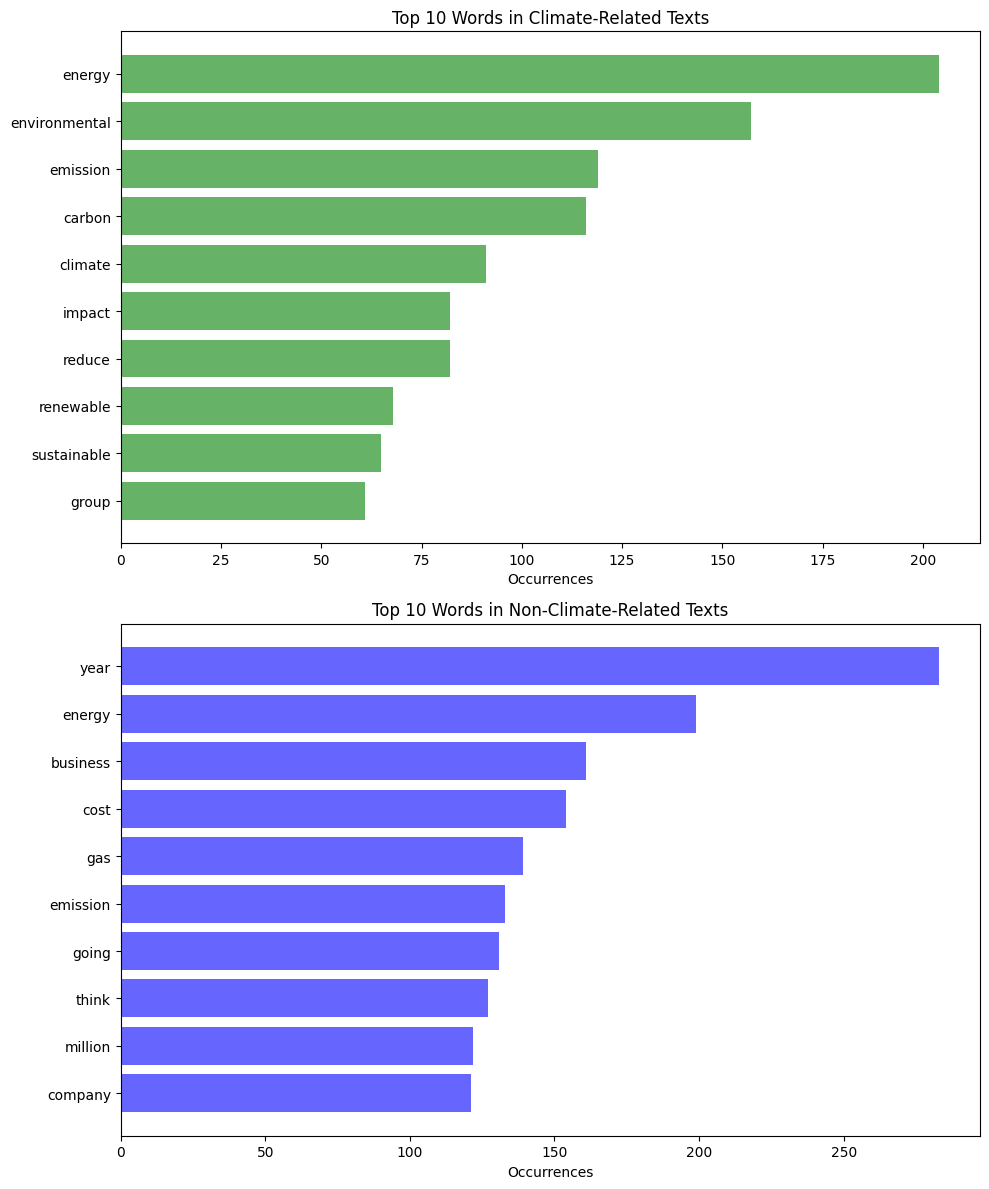

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

df_climate_word_counts_10 = df_climate_word_counts.head(10)
df_non_climate_word_counts_10 = df_non_climate_word_counts.head(10)

#climate-related texts
axes[0].barh(df_climate_word_counts_10['Word'], df_climate_word_counts_10['Count'], color='green', alpha=0.6)
axes[0].set_title('Top 10 Words in Climate-Related Texts')
axes[0].set_xlabel('Occurrences')
axes[0].invert_yaxis()  # Highest values at the top

#non-climate-related texts
axes[1].barh(df_non_climate_word_counts_10['Word'], df_non_climate_word_counts_10['Count'], color='blue', alpha=0.6)
axes[1].set_title('Top 10 Words in Non-Climate-Related Texts')
axes[1].set_xlabel('Occurrences')
axes[1].invert_yaxis()  # Highest values at the top

#show the plots
plt.tight_layout()
plt.show()

The total count of unique words compared shows, that the domain of Environmental claims is significantly narrower than the domain of the other sentences.